<center>Author: Yury Kashnitsky (@yorko)</center>

# Intro

Here I train a mapping model with COCO captions. I realized that COCO captions is almost an ideal source to train the mapping model, although it covers a bit more than 50% of ImageNet classes and only 155 are left when we select those classes known to BERT (possible [improvements](#Possible-improvements) are discussed in the end).

I select only those captions containing exactly **one** word from ImageNet classes.

<center>a [UNK] stop sign and a red [UNK] on the road $\rightarrow$ sign <br>
the vanity contains two sinks with a towel for each $\rightarrow$ towel<br>
 a person [UNK] from the rain by their umbrella walks down the road $\rightarrow$ umbrella<br>
 two bicycles and a woman walking in front of a shop $\rightarrow$ shop <br>
 a brown horse is grazing grass near a red house $\rightarrow$ horse </center>


The model itself is just a dense layer, so it performs a linear mapping of BERT hidden states to BigGAN class embeddings

<img src='../img/multi-modal-code-exercise.png'>

Mapping model input is sized `[max_seq_len x lm_hidden_size]` [15 x 768] <br>
Mapping model output is sized `[max_seq_len x biggan_class_emb_dim]` [15 x 128]

The model behavior is analyzed in the end of this notebook (GIFs are also present in the README). Also, possible improvements are listed. 

**<font color='red'>Disclaimer:</font>** This is a "researchy" Jupyter notebook, it gives a good idea of how I approached the problem, it's also good to analyze model behavior and, in general, to present stuff. But the code quality shall not be judged here :) For this purpose, better refer to the application - `multimodal-code-exercise-yorko`. At least docstrings are properly written there.

# Plan

- [Prepare COCO captions](#Prepare-COCO-captions)
 - [Load COCO captions](#Load-COCO-captions)
 - [Select ImageNet classes](#Select-ImageNet-classes)
 - [Filter and process COCO captions](#Filter-and-process-COCO-captions)
 - [Explore COCO captions](#Explore-COCO-captions)

- [Create training set](#Create-training-set)
 - [LM hidden states (mapping model input)](#LM-hidden-states-(mapping-model-input))
 - [BigGan class embeddings (mapping model target)](#BigGan-class-embeddings-(mapping-model-target))
 - [Torch Dataset to train the mapping model](#Torch-Dataset-to-train-the-mapping-model)
 - [Data loaders for the mapping model](#Data-loaders-for-the-mapping-model)
 - [Mapping model](#Mapping-model)
 
- [Training the mapping model](#Training-the-mapping-model)
 - [Overfitting a toy dataset](#Overfitting-a-toy-dataset)
 - [Full training](#Full-training)
 - [Loading the best checkpoint](#Loading-the-best-checkpoint)
 
- [Playing around with the model](#Playing-around-with-the-model)
 - [Good cases](#Good-cases)
 - [Bad cases](#Bad-cases)
 - [The "poem" from an example by Thomas](#The-"poem"-from-an-example-by-Thomas)
 
- [Retrospective](#Retrospective)
 - [Good traits of the built solution](#Good-traits-of-the-built-solution)
 - [Bad traits of the built solution](#Bad-traits-of-the-built-solution)
 - [What didn't work](#What-didn't-work)
 - [Possible improvements](#Possible-improvements)

In [1]:
# For full reproducibility, install additional packages
# mentioned in ../requirement-optional.txt

# basic Python imports
import os
import sys
sys.path.append('../scripts/')
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

# NLTK
import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn

# Visualization
from matplotlib import pyplot as plt
from IPython import display
%config InlineBackend.figure_format = 'retina'

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# 3rd party and custom scripts 
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from pytorch_pretrained_biggan.utils import IMAGENET, one_hot_from_names, save_as_images
from transformers import AutoTokenizer, AutoModel
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample

# Prepare COCO captions
### Load COCO captions

_[back to Intro](#Intro)_

Here we utilize the `load_coco_data` script from Stanford's cs231n course. We end up with ~400k training captions and 200k validation captions.

In [2]:
## First, get COCO data
#!sh ../scripts/get_coco_captioning.sh
#!mv coco_captioning ../data

In [3]:
coco_data = load_coco_data(base_dir='../data/coco_captioning/')

In [4]:
coco_data['train_captions'].shape, coco_data['val_captions'].shape

((400135, 17), (195954, 17))

In [5]:
train_captions = [decode_captions(coco_data['train_captions'][i],
                                  coco_data['idx_to_word'])
                  for i in range(coco_data['train_captions'].shape[0])]
val_captions = [decode_captions(coco_data['val_captions'][i],
                                coco_data['idx_to_word'])
                  for i in range(coco_data['val_captions'].shape[0])]

In [6]:
train_captions[:5]

['<START> a very clean and well decorated empty bathroom <END>',
 '<START> a <UNK> view of a kitchen and all of its appliances <END>',
 '<START> a blue and white bathroom with <UNK> <UNK> wall <UNK> <END>',
 '<START> a <UNK> photo of a kitchen and dining room <END>',
 '<START> a <UNK> stop sign across the street from a red car <END>']

### Select ImageNet classes

_[back to Intro](#Intro)_

The code is reused from `multimodal-code-exercise/prepare_data.py` by HuggingFace. The comment is also taken from there:

 > Some classes in ImageNet are associated to complex and rare words like breeds of dog. To make it simpler for us in the first step, we'll filter the words to associate a more common word to each class or remove the class if we can't find a common word or if all the common words associated to the class are already taken. A common word here is a word that is in Bert tokenizer vocabulary.

In [7]:
class_to_synset = dict((v, wn.synset_from_pos_and_offset('n', k)) 
                       for k, v in IMAGENET.items())

In [8]:
# Initialize DistilBERT tokenizer
lm_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [9]:
words_dataset = {}
all_words = set()
for i, synset in tqdm(class_to_synset.items()):
    current_synset = synset
    while current_synset:
        for lemma in current_synset.lemmas():
            name = lemma.name().replace('_', ' ').lower()
            if name in all_words:
                continue  # Word is already assigned
            if lm_tokenizer.convert_tokens_to_ids(name) != lm_tokenizer.unk_token_id:
                # Word is in Bert tokenizer vocabulary
                words_dataset[i] = name
                all_words.add(name)
                current_synset = False # We're good
                break
        if current_synset and current_synset.hypernyms():
            current_synset = current_synset.hypernyms()[0]
        else:
            current_synset = False

We are left with about 600 classes out of 1000. 

In [10]:
len(words_dataset)

598

### Filter and process COCO captions

_[back to Intro](#Intro)_

 - Replace \<\UNK\> with [UNK]
 - strip start and end tokens
 - select only captions with one ImageNet word
 
 
Thus, we are left with 162k train captions and 79k validation captions.

In [11]:
def filter_and_process_captions(captions, imagenet_words):
    
    result, labels = [], []
    for caption in captions:
        common_words = list(set(caption.split()).intersection(imagenet_words))

        if len(common_words) == 1:
            result.append(caption.replace('<START>', '').replace('<END>', '')\
                      .replace('<UNK>', '[UNK]').strip())
            labels.append(common_words[0])
    return result, labels

In [12]:
train_captions, train_labels = filter_and_process_captions(train_captions, all_words)
val_captions, val_labels = filter_and_process_captions(val_captions, all_words)

In [13]:
len(train_captions), len(val_captions)

(162119, 79311)

In [14]:
train_captions[:5]

['a [UNK] stop sign and a red [UNK] on the road',
 'the vanity contains two sinks with a towel for each',
 'a person [UNK] from the rain by their umbrella walks down the road',
 'two bicycles and a woman walking in front of a shop',
 'a brown horse is grazing grass near a red house']

In [15]:
train_labels[:5]

['sign', 'towel', 'umbrella', 'shop', 'horse']

### Explore COCO captions

In [16]:
imagenet_class_distibution_coco = {word: 0 for word in all_words}
num_imagenet_classes_per_caption = []
caption_len = []

for caption in tqdm(train_captions):
    common_words = set(caption.split()).intersection(all_words)
    
    num_imagenet_classes_per_caption.append(len(common_words))
    caption_len.append(len(caption.split()))
    for word in common_words:
        imagenet_class_distibution_coco[word] += 1

Train captions are 15 max in length, 10 in median

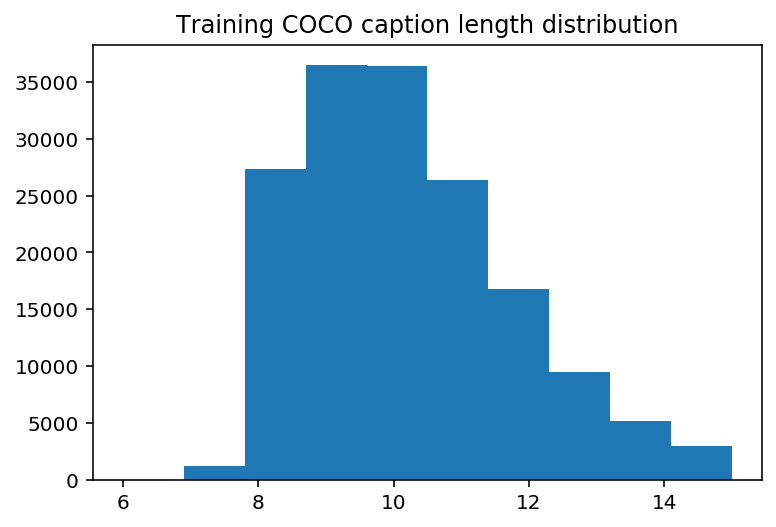

In [17]:
plt.hist(caption_len);
plt.title("Training COCO caption length distribution");

From now on, this 15 will be maximal sequence length. In principle, can be increased.

In [18]:
MAX_SEQ_LEN = 15

Many of ImageNet classes are not there in train COCO captions. [Improvements](#Possible-improvements) are discussed in the end of this notebook.

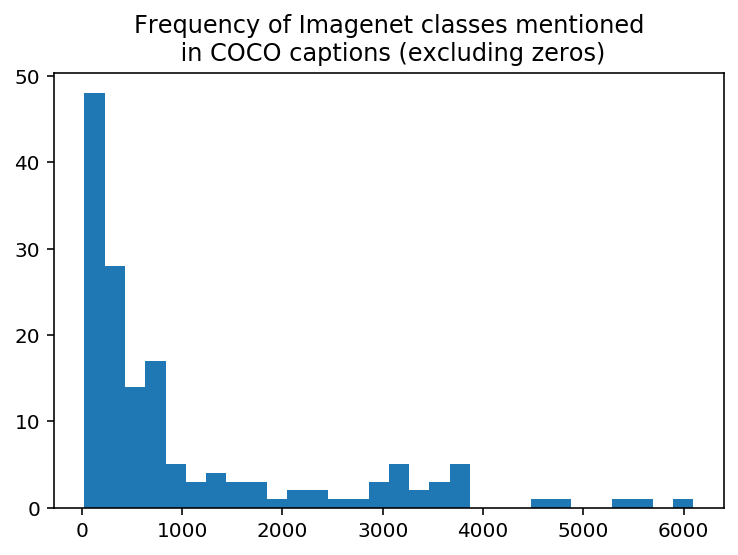

In [19]:
freqs = np.array(list(imagenet_class_distibution_coco.values()))
plt.hist(freqs[freqs > 0], bins=30);
plt.title("Frequency of Imagenet classes mentioned\n in COCO captions (excluding zeros)");

In [20]:
# Top presented ImageNet classes 
sorted(imagenet_class_distibution_coco.items(), key=lambda pair: -pair[1])[:10]

[('bus', 6095),
 ('dog', 5609),
 ('sign', 5310),
 ('ball', 4713),
 ('top', 4545),
 ('baseball', 3858),
 ('horse', 3797),
 ('plate', 3789),
 ('board', 3772),
 ('bed', 3713)]

In [21]:
# Some of absent ImageNet classes  
# They are found in ImageNet but not in COCO captions
sorted(imagenet_class_distibution_coco.items(), key=lambda pair: -pair[1])[-10:]

[('omnibus', 0),
 ('key', 0),
 ('lobster', 0),
 ('castle', 0),
 ('bank', 0),
 ('covert', 0),
 ('finch', 0),
 ('barn', 0),
 ('bikini', 0),
 ('handkerchief', 0)]

In [22]:
print("{} classes are ignored.\n{} classes matched.".format(
    sum([1 for (k, v) in imagenet_class_distibution_coco.items() if v == 0]), 
    sum([1 for (k, v) in imagenet_class_distibution_coco.items() if v > 0])
))

443 classes are ignored.
155 classes matched.


Save train and validation COCO captions

In [23]:
with open('../data/train_coco_captions_one_class.pkl', 'wb') as f:
    pickle.dump(train_captions, f)
with open('../data/val_coco_captions_one_class.pkl', 'wb') as f:
    pickle.dump(val_captions, f)

# Create training set
### LM hidden states (mapping model input)

We further use either GPU or CPU depending on the device on board. 

In [24]:
torch_device = torch.device('cuda' 
                            if torch.cuda.is_available() 
                            else 'cpu') 

In [25]:
# Now we also initialize the DistilBERT model
lm_model = AutoModel.from_pretrained('distilbert-base-uncased')
lm_model.to(torch_device);

The following function:
 - encodes the given text
 - applies padding for short texts or trims long ones
 - returns BERT hidden states shaped [max_seq_length x hidden size]

In [26]:
def encode_text_input(text, 
                      tokenizer, 
                      language_model, 
                      max_seq_length=MAX_SEQ_LEN,
                      torch_device=torch.device('cpu')):
    
    pad_vid = lm_tokenizer.vocab["[PAD]"]
    
    # encoding the text
    text_encoded = tokenizer.encode(
            text,
            add_special_tokens=True,
            max_length=max_seq_length,
            return_tensors="pt",
        )
    
    # padding short texts
    true_seq_length = text_encoded.size(1)
    pad_size = max_seq_length - true_seq_length
    if pad_size > 0:
        pad_ids = torch.Tensor([pad_vid] * pad_size).long().view([-1, pad_size])
        text_encoded_padded_or_trimmed = torch.cat((text_encoded, pad_ids), dim=1)
    else:
        text_encoded_padded_or_trimmed = text_encoded[:max_seq_length]
    
    text_encoded_padded_or_trimmed = text_encoded_padded_or_trimmed.to(torch_device)

    
    with torch.no_grad():
        # Last layer hidden-states are the first output of 
        # Transformers' library models output tuple
        lm_hidden_states = language_model(text_encoded_padded_or_trimmed)[0]
        
        # Keep first example in the batch - output shape (max_seq_length, hidden size)
        lm_hidden_states_first_example = lm_hidden_states[0] 
    
    return lm_hidden_states_first_example

Example usage

In [27]:
res = encode_text_input(text='A dog is faster than a cat',
                       tokenizer=lm_tokenizer, language_model=lm_model,
                       torch_device=torch_device)
res.size()

torch.Size([15, 768])

### BigGAN class embeddings (mapping model target)

In [28]:
gan_model = BigGAN.from_pretrained('biggan-deep-128')
gan_model.to(torch_device);

The following function:
 - splits the given text
 - applies padding for short texts or trims long ones
 - takes ImageNet `label` BigGAN embedding (zeros if `label` is not found)
 - return a tensor shaped [max_seq_len x emb_size] - `max_seq_len` identical 128-long BigGAN embeddings

In [29]:
def create_biggan_embeggings(text, label, gan_model,
                             max_seq_len=MAX_SEQ_LEN,
                            torch_device=torch.device('cpu')):
    
    result = []
    tokens = text.split()
    
    if len(tokens) < max_seq_len:
        tokens += ['[PAD]' for _ in range(max_seq_len - len(tokens))]
    else:
        tokens = tokens[:max_seq_len]
    
    for token in tokens:
        # create a 1000-long OHE-vector indicating the ImageNet class for `label`
        # a bit ugly to use try/except logic in code, but good enough here
        try:
            class_vector = torch.tensor(one_hot_from_names(label)) 
        except AssertionError:
            # zeros if `label` is not found
            class_vector = torch.zeros([1, 1000])
            
        class_vector = class_vector.to(torch_device)
        # BigGAN embedding
        result.append(gan_model.embeddings(class_vector))
        
    with torch.no_grad():   
        result = torch.cat(result)
    
    return result

Example usage

In [30]:
res = create_biggan_embeggings(text='A dog is faster than a cat',
                               label='dog',
                               gan_model=gan_model, 
                               max_seq_len=15,
                              torch_device=torch_device)
res.size()

torch.Size([15, 128])

### Torch Dataset to train the mapping model

In [31]:
class MappingDataset(Dataset):
    def __init__(self,
                 captions,
                 labels,
                 tokenizer,
                 language_model,
                 gan_model, 
                 max_seq_length=MAX_SEQ_LEN,
                 torch_device=torch.device('cpu')):

        self.captions = captions   
        self.labels = labels
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.language_model = language_model
        self.gan_model = gan_model
        self.torch_device = torch_device
    
    def __len__(self):
        """
        Returns:
            int: length of the dataset
        """
        return len(self.captions)   

    def __getitem__(self, index):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        # encoding the text
        caption = self.captions[index]
        
        # class label
        label = self.labels[index]
        
        # get hidden states - input to the mapping model
        lm_hidden_states = encode_text_input(caption, 
                                             self.tokenizer,
                                             self.language_model,
                                             self.max_seq_length,
                                             self.torch_device)
        
        # get BigGAN embeddings - target for the mapping model
        gan_embeddings = create_biggan_embeggings(caption,
                                                  label,
                                                  self.gan_model,
                                                  self.max_seq_length,
                                                  self.torch_device)
        
        return lm_hidden_states, gan_embeddings

In [32]:
train_dataset = MappingDataset(train_captions, 
                               train_labels,
                               tokenizer=lm_tokenizer,
                               language_model=lm_model,
                               gan_model=gan_model,
                               torch_device=torch_device)

# this will be used to overfit a small sample
toy_train_dataset = MappingDataset(train_captions[:100], 
                                   train_labels[:100],
                                   tokenizer=lm_tokenizer,
                                   language_model=lm_model,
                                   gan_model=gan_model,
                                   torch_device=torch_device)

In [33]:
val_dataset = MappingDataset(val_captions, 
                             val_labels,
                             tokenizer=lm_tokenizer,
                             language_model=lm_model,
                             gan_model=gan_model,
                             torch_device=torch_device)

In [34]:
len(train_dataset), len(val_dataset)

(162119, 79311)

Showing one of Dataset items

In [35]:
train_captions[4]

'a brown horse is grazing grass near a red house'

In [36]:
lm_hidden_states, gan_embeddings = train_dataset[4]

In [37]:
lm_hidden_states.size(), gan_embeddings.size()

(torch.Size([15, 768]), torch.Size([15, 128]))

### Data loaders for the mapping model

In [38]:
BATCH_SIZE = 128

In [39]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

toy_train_loader = DataLoader(dataset=toy_train_dataset,
                          batch_size=32, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

### Mapping model

This is just a Linear layer. It's output is compared to true BigGAN embeddings via MSE loss.

<img src='../img/linear-mapping.png' width=50%>

- $X$ - BERT hidden states for the text input, $[max\_seq\_len \times bert\_hidden\_size]$
- $Z$ - BigGAN embeddings for each input token, $[max\_seq\_len \times gan\_emb\_size]$
- $W$ - mapping matrix, learned below, $[bert\_hidden\_size \times gan\_emb\_size]$
- $max\_seq\_len$ = 15 - maximal sequence length in words, shorter texts are padded, longer ones are trimmed
- $bert\_hidden\_size$ = 768 - dimensionality of BERT (or DistilBERT) LM output hidden states
- $gan\_emb\_size$ = 128 - dimensionality of BigGAN class embeddings

In [40]:
BERT_HIDDEN_SIZE = 768
MAPPING_OUTPUT_SIZE = 128

NUM_EPOCHS = 10
LEARN_RATE = 5e-3
loss_fn = torch.nn.MSELoss(reduction='mean')

In [41]:
mapping_model = torch.nn.Sequential(
          torch.nn.Linear(BERT_HIDDEN_SIZE, MAPPING_OUTPUT_SIZE),
        )

In [42]:
mapping_model

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
)

# Training the mapping model

For training, I use the [Catalyst](https://github.com/catalyst-team/catalyst) framework, only the `Runner` object which here serves only to replace the usual PyTorch training loop. The Catalyst runner takes care of:
 - running the Pytorch model with provided optimizer, scheduler
 - logging (can be further nicely visualized)
 - gradient accumulation
 - mixed-precision training
 - scoring callbacks
 - checkpointing
 - etc. 

It also stores all logs, metrics, checkpoint and training code in one place. So experiments can be more or less easily reproduced. 

Catalyst was mostly used for CV and RL, I brought [first NLP pipelines](https://github.com/catalyst-team/catalyst/tree/master/examples/distilbert_text_classification) there. 

Just in case you are interested - [a tutorial](https://www.kaggle.com/kashnitsky/distillbert-catalyst-amazon-product-reviews) (DistilBERT + Catalyst for text classification). But it's not necessary for the following. 

In [43]:
import catalyst
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import EarlyStoppingCallback, CriterionCallback
from catalyst.dl.utils import set_global_seed, prepare_cudnn, plot_metrics

In [44]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mapping_model.parameters(), lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [45]:
runner = SupervisedRunner()

### Overfit a toy dataset

In [46]:
LOG_DIR = '../training_logs/toy/'

In [47]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"    # can be changed in case of multiple GPUs onboard
set_global_seed(17)                         # reproducibility
prepare_cudnn(deterministic=True)           # reproducibility

First, we overfit a small toy set (commented out here for faster reproducibility of the notebook).

In [48]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "1"  

# runner.train(
#     model=mapping_model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     loaders={'train': toy_train_loader},
#     callbacks=[
#         CriterionCallback(),
#         EarlyStoppingCallback(patience=10)
#     ],
#     logdir=LOG_DIR,
#     num_epochs=50
# )

In [49]:
plot_metrics(
    logdir=LOG_DIR,
    step='epoch',
    metrics=['loss']
)

### Full training

We can overfit a small set, that's good. Now full training. Commented out here - actually done with a script based on this notebook. The script is not tidied up and thus not added to the repo, but it's fully based on this notebook. 

In [50]:
LOG_DIR = '../training_logs/'

In [51]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "1" 
# runner.train(
#     model=mapping_model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     loaders={'train': train_loader, 'valid': val_loader},
#     callbacks=[
#         CriterionCallback(),
#         EarlyStoppingCallback(patience=10)
#     ],
#     logdir=LOG_DIR,
#     num_epochs=3,
#     verbose=False
# )

In [52]:
plot_metrics(
    logdir=LOG_DIR,
    step='batch',
    metrics=['loss']
)

### Loading the best checkpoint

Checkpoints are saved here by Catalyst

In [53]:
!ls $LOG_DIR/checkpoints

best_full.pth  _metrics.json  train.10_full.pth


In [54]:
checkpoint = torch.load(Path(LOG_DIR) / 'checkpoints' / 'best_full.pth',
                       map_location=torch_device)

mapping_model_full = torch.nn.Sequential(
          torch.nn.Linear(BERT_HIDDEN_SIZE, MAPPING_OUTPUT_SIZE)
        )

mapping_model_full.load_state_dict(checkpoint['model_state_dict'])
mapping_model_full.to(torch_device)
mapping_model_full.eval()

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
)

# Playing around with the model

Let's pick up one of examples

In [55]:
train_captions[4], train_labels[4]

('a brown horse is grazing grass near a red house', 'horse')

In [56]:
text = train_captions[4]

In [57]:
hidden_states = encode_text_input(text,
                       tokenizer=lm_tokenizer, language_model=lm_model,
                                 torch_device=torch_device)

mapping_model_output = mapping_model_full(hidden_states)

gan_embs = create_biggan_embeggings(text, train_labels[4], 
                                    gan_model, max_seq_len=15,
                                   torch_device=torch_device)

print("Hidden states size: {}\nMapping model output size: {}\nGAN embs size: {}".format(
    hidden_states.size(), mapping_model_output.size(), gan_embs.size()))

Hidden states size: torch.Size([15, 768])
Mapping model output size: torch.Size([15, 128])
GAN embs size: torch.Size([15, 128])


To visualize, we use methods defined by HuggingFace in the `run_model.py` file - I've copied `print_image` and also adapted a bit the `generate_image` method to be able to generate a mini-batch of images (`generate_images`).

In [58]:
from PIL import Image

def print_image(numpy_array):
    """

    Utility function to print a numpy uint8 array as an image

    :param numpy_array: a NumPy array shaped [width x height x 3]
    :return: None
    """
    img = Image.fromarray(numpy_array)
    plt.imshow(img)
    plt.show()


def generate_images(dense_class_vector=None, name=None, noise_seed_vector=None,
                    truncation=0.4, gan_model=None,
                    pretrained_gan_model_name='biggan-deep-128',
                    batch_size=15, torch_device=torch.device('cpu')):
    """

    :param dense_class_vector: used as a replacement of BigGAN internal
            ImageNet class embeddings (torch.Tensor with 128 elements)
    :param name: converted in an associated ImageNet class and then
            a dense class embedding using BigGAN's internal ImageNet
            class embeddings (string)
    :param noise_seed_vector: a vector used to control the seed
            (seed set to the sum of the vector elements)
    :param truncation: a float between 0 and 1 to control image quality/diversity
            tradeoff (see BigGAN paper)
    :param gan_model: a BigGAN model from pytorch_pretrained_biggan library.
                If None a model is instanciated from a pretrained model name given
                by `pretrained_gan_model_name`. List of possible names:
                https://github.com/huggingface/pytorch-pretrained-BigGAN#models
    :param pretrained_gan_model_name: shortcut name of the GAN model to instantiate
            if no gan_model is provided. Default to 'biggan-deep-128'
    :param batch_size: number of images to generate
    :return: a tuple with two numpy arrays, the first one is shaped
            [batch_size, 128, 128, 3], the second one is a raw output
            from BigGAM generator, used to save images
    """

    seed = int(noise_seed_vector.sum().item()) if noise_seed_vector is not None else None
    noise_vector = truncated_noise_sample(truncation=truncation,
                                          batch_size=batch_size, seed=seed)
    noise_vector = torch.from_numpy(noise_vector).to(torch_device)
    if gan_model is None:
        gan_model = BigGAN.from_pretrained(
            pretrained_gan_model_name).to(torch_device)
    if name is not None:
        class_vector = one_hot_from_names([name], batch_size=batch_size)
        class_vector = torch.from_numpy(class_vector).to(torch_device)
        dense_class_vector = gan_model.embeddings(class_vector)
    else:
        dense_class_vector = dense_class_vector.view(-1, 128)
    input_vector = torch.cat([noise_vector, dense_class_vector], dim=1)

    # Generate an image
    with torch.no_grad():
        output = gan_model.generator(input_vector, truncation)
        raw_biggan_output = output.clone()

    output = output.cpu().numpy()
    output = output.transpose((0, 2, 3, 1))

    if batch_size == 1:
        output = output[0]

    output = ((output + 1.0) / 2.0) * 256
    output.clip(0, 255, out=output)
    output = np.asarray(np.uint8(output), dtype=np.uint8)
    return output, raw_biggan_output

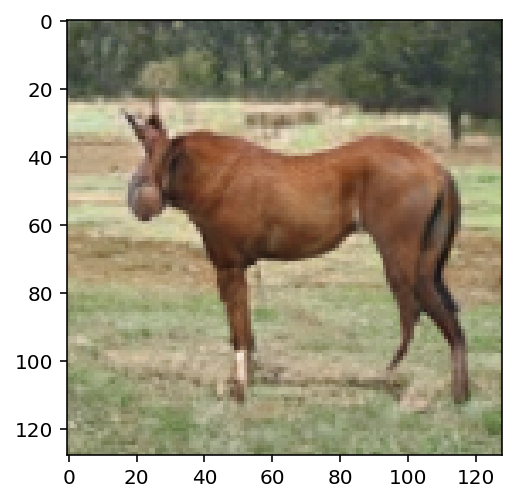

In [59]:
# horse
# index 0 corresponds to the [CLS] token, so "horse" here is indexed with 3
print_image(generate_images(mapping_model_output[3], batch_size=1,
                           torch_device=torch_device)[0])

In [60]:
def play(text, generated_images, pause_time=0.5):
    
    words = text.split()

    for i, img in enumerate(generated_images[1:len(words)+1]):
        plt.figure(1); plt.clf()
        title = '{} {} {}'.format(" ".join(words[:i]), 
                                  words[i].upper(),
                                  " ".join(words[i+1:]))
        plt.title(title)
        img = plt.imshow(img)
        plt.pause(pause_time)
        display.clear_output(wait=True)

In [61]:
def play_slideshow(text, save_as_images_filename,
                  torch_device=torch.device('cpu')):
    
    words = text.split()
    
    hidden_states = encode_text_input(text,
                       tokenizer=lm_tokenizer, language_model=lm_model,
                                     torch_device=torch_device)
    mapping_model_output = mapping_model_full(hidden_states)
    generated_images, raw_biggan_output = generate_images(
        dense_class_vector=mapping_model_output,
        torch_device=torch_device)
    play(text, generated_images)
    
    if save_as_images_filename:
        save_as_images(raw_biggan_output[1:len(words)+1].cpu(),
                       file_name=save_as_images_filename)

### Good cases
This approach works fairly well with classes well presented in COCO captions, eg. dog, bus, shop, coffee, sign.

In [62]:
%%time
play_slideshow("a dog is faster than a cat",
               save_as_images_filename='../img/ex1_dog',
              torch_device=torch_device)

CPU times: user 6.62 s, sys: 724 ms, total: 7.34 s
Wall time: 10.1 s


Note: this slideshow can also be played with a script `../scripts/display_image_series.py`:
        
     python display_image_series.py --file_mask ex1_dog --text "a dog is faster than a cat"

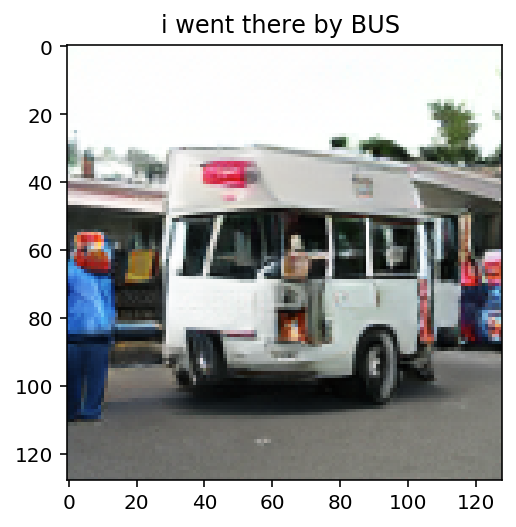

In [63]:
play_slideshow("i went there by bus",
               save_as_images_filename='../img/ex2_bus',
              torch_device=torch_device)

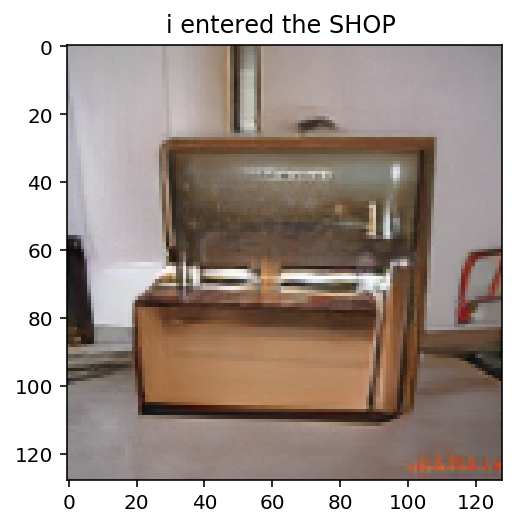

In [64]:
play_slideshow("i entered the shop",
              save_as_images_filename='../img/ex3_shop',
              torch_device=torch_device)

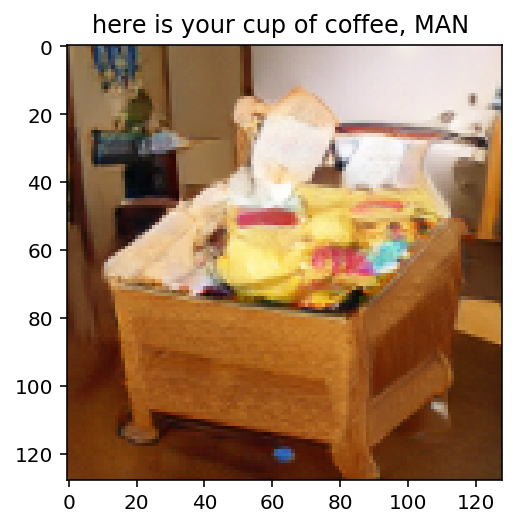

In [65]:
play_slideshow("here is your cup of coffee, man",
              save_as_images_filename='../img/ex4_coffee',
              torch_device=torch_device)

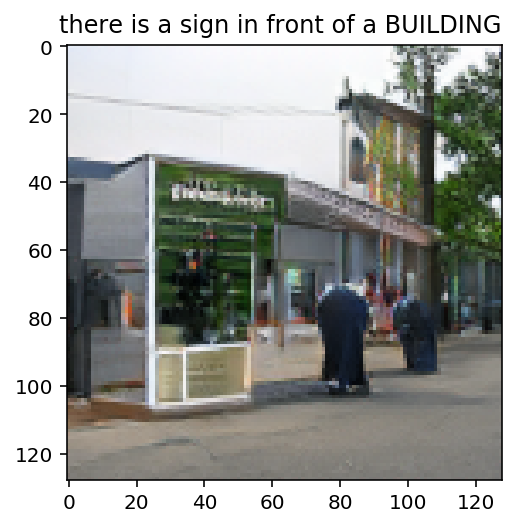

In [66]:
play_slideshow("there is a sign in front of a building",
              save_as_images_filename='../img/ex5_sign_building',
              torch_device=torch_device)

### Bad cases

Some of classes are present in COCO captions but still are dominated by other objects.

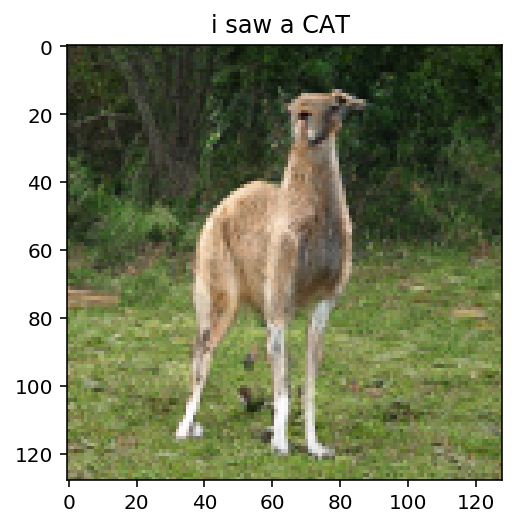

In [67]:
play_slideshow("i saw a cat",
              save_as_images_filename='../img/ex6_cat',
              torch_device=torch_device)

Other classes are just not present in COCO captions, eg. cobra or volcano

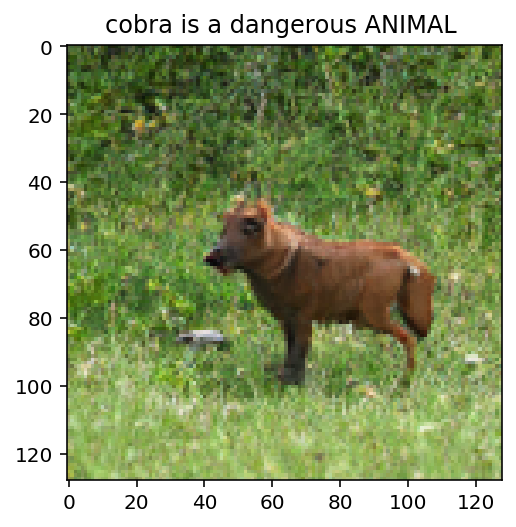

In [68]:
play_slideshow('cobra is a dangerous animal',
              save_as_images_filename='../img/ex7_cobra',
              torch_device=torch_device)

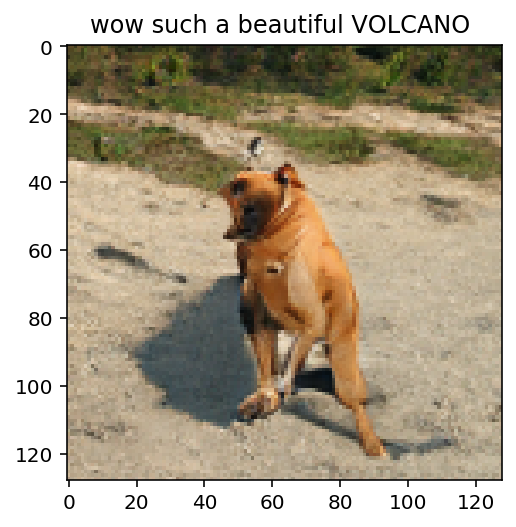

In [69]:
play_slideshow('wow such a beautiful volcano',
              save_as_images_filename='../img/ex8_volcano',
              torch_device=torch_device)

The model doesn't seem to cope with >1 class in a caption. In this example, we have both "elephant" and "bus", and some funny mixtures of animals and means of transport are produced. 

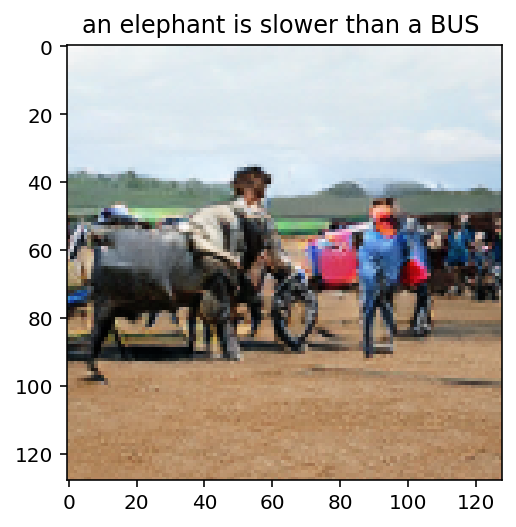

In [70]:
play_slideshow('an elephant is slower than a bus',
              save_as_images_filename='../img/ex9_elephant',
              torch_device=torch_device)

### The "poem" from an example by Thomas

Draws some persons and interiors, good

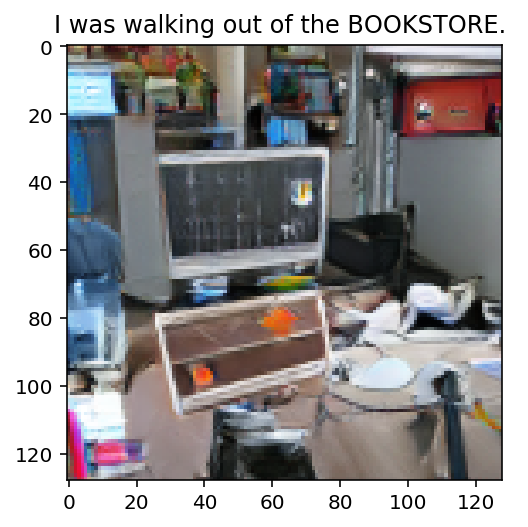

In [71]:
play_slideshow('I was walking out of the bookstore.',
              save_as_images_filename='../img/ex_poem1',
              torch_device=torch_device)

Fails with volcano, though show smth reasonable for "background"

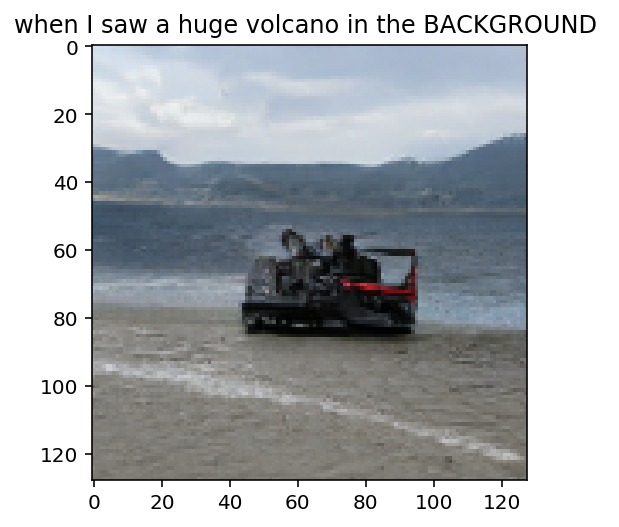

In [72]:
play_slideshow('when I saw a huge volcano in the background',
              save_as_images_filename='../img/ex_poem2',
              torch_device=torch_device)

Draws some persons and a park, good

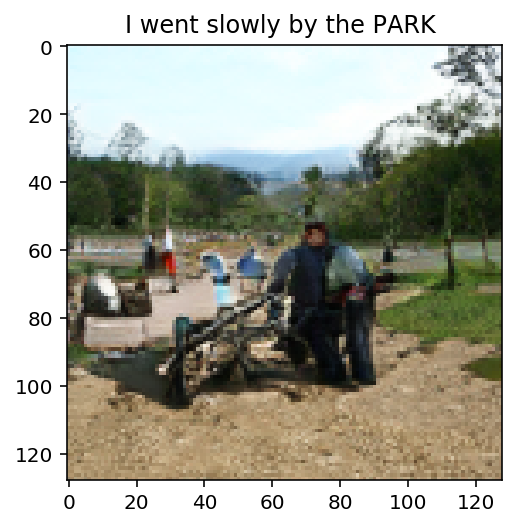

In [73]:
play_slideshow('I went slowly by the park',
              save_as_images_filename='../img/ex_poem3',
              torch_device=torch_device)

Draws persons, good

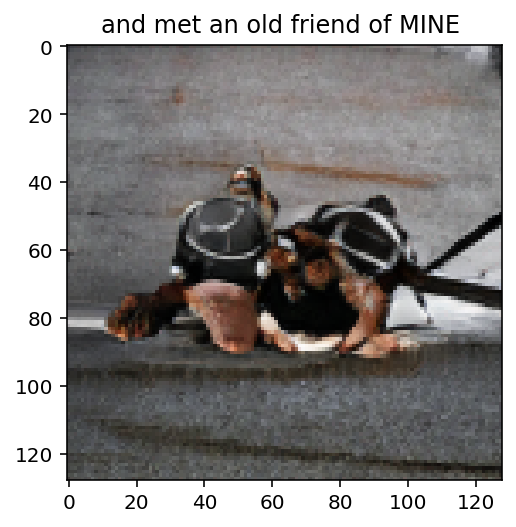

In [74]:
play_slideshow('and met an old friend of mine',
              save_as_images_filename='../img/ex_poem4',
              torch_device=torch_device)

# Retrospective

### Good traits of the built solution

- The mapping is done with a simple model (a linear mapping) and it's shown to work for some ImageNet classes 
- The model copes fairly enough with images corresponding to ImageNet classes that are well presented in COCO captions. eg. bus, sign, coffee and, of course, dog. 
- It also copes pretty well with the "poem" (I was walking out of the bookstore \ when I saw a huge volcano in the background \ I went slowly by the park \ and met an old friend of mine)

### Bad traits of the built solution

- Only 155 ImageNet classes are there in training COCO captions, so we fail to visualize some concepts like cobra or volcano
- The model doesn't seem to cope with >1 class in a caption, eg. "a dog is faster that a cat" - only dogs are drawn. Or "an elephant is slower than a bus" - some funny mixtures of animals and means of transport are produced.

### What didn't work

- Keeping original captions with up to 8 ImageNet words in each one. Thus the target BigGAN embedding matrix contains embeddings for more than one class. In my case the model failed to learn anything
- Replacing simple linear mapping with a more complex MLP didn't improve results
- Tried adding simple patterns to COCO captions, actually had a template for several patterns, each one produced 1k examples like "I noticed a truck", "she saw a sign" etc. The model didn't train well for me, probably just a matter of learning rate


### Possible improvements

> List some improvements you would propose to improve this data generation process 

Here I address both "Building a dataset of text sequence associated to ImageNet classes" and "Building a dataset for training a mapping function" parts of the provided assignment. 

- Here I used COCO captions. This covered 155 ImageNet classes out of 598 that we used here. But actually, any text will do as long as it contains ImageNet classes. So the training dataset can be extended with eg. extracts from Wikipedia pages with corresponding words ("Lion", "Cheetah", "Volcano" etc.)
- Adding synthetic captions. With a template like "\<<SUBJ\>> \<<VERB\>> \<<WORD\>> \<<PLACE\>>" we can generate as many captions as we wish if we vary subject (I, he, she, we, they etc.), verb (saw, noticed, spotted etc.), place (here, there, in front of the building etc) and word (1k ImageNet classes). As I mentioned, I didn't train a better model with these synthetic captions, but still it's a good way to extend the training set for the mapping model
- Augmentations, eg. synonym replacement. We didn't find the word "beast" in COCO captions, but we can take existing ones with words "lion" or "tiger" and replace them with the word "beast" to get new captions. 
    
More remarks:
 - The training dataset can be further enlarged with other captions, eg. [Conceptual Captions](https://ai.googleblog.com/2018/09/conceptual-captions-new-dataset-and.html)
 - Technically, training could have been done better, eg. with LR Finder
 - A more complicated model can be trained, eg. a MLP